In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams["figure.dpi"] = 150
import ipywidgets as widgets
from particle import PDGID
import sys
sys.path.append("../../../Muon_Collider_Smart_Pixels/daniel/validationPlots")
from plotUtils import *
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

from coordinateValidation_Utils import *

In [2]:
sensorAngles = np.arange(-np.pi-np.pi/8,np.pi+2*np.pi/8,np.pi/8)


In [3]:
sig = pd.read_csv('/local/d1/smartpixML/2026Datasets/Data_Files/Data_Set_flp_0/Track_Lists/signal_tracks_extra_info_0.txt', sep=' ')
print(len(sig))

5038


-3.5342917352885173 8
-3.141592653589793 9
-2.748893571891069 10
-2.356194490192345 11
-1.9634954084936207 12
-1.5707963267948966 13
-1.1780972450961724 14
-0.7853981633974483 15
-0.39269908169872414 16
0.0 1
0.39269908169872414 2
0.7853981633974478 3
1.1780972450961724 4
1.570796326794897 5
1.9634954084936207 6
2.3561944901923444 7
2.748893571891069 8
3.1415926535897936 9
3.5342917352885173 10


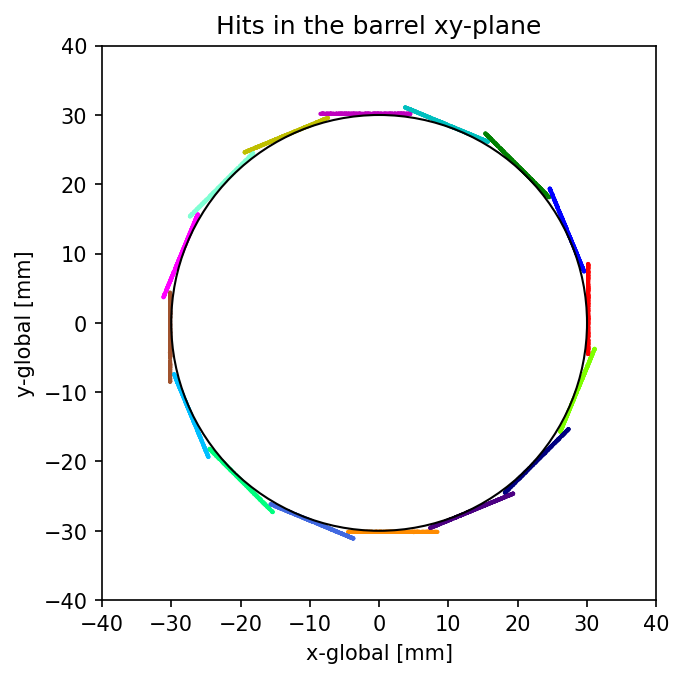

In [4]:
for i in range(len(sensorAngles)):
    print(sensorAngles[i], moduleIDs[i])
uniqueGammas = np.unique(sig['gamma'])
plotHits(sig,uniqueGammas)

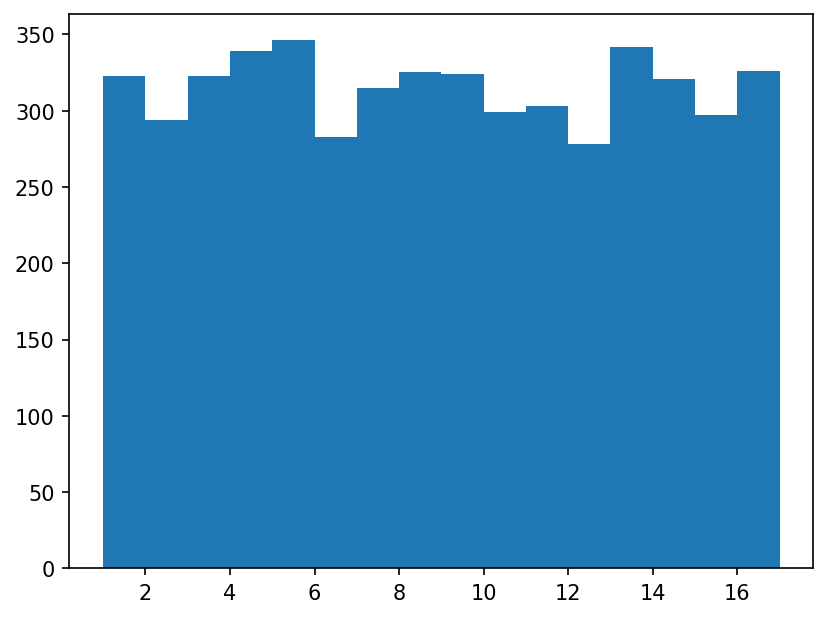

[0.      0.3927  0.7854  1.1781  1.5708  1.9635  2.35619 2.74889 3.14159
 3.53429 3.92699 4.31969 4.71239 5.10509 5.49779 5.89049]
[0.         0.39269908 0.78539816 1.17809725 1.57079633 1.96349541
 2.35619449 2.74889357 3.14159265 3.53429174 3.92699082 4.3196899
 4.71238898 5.10508806 5.49778714 5.89048623]


In [5]:
plt.hist(sig['moduleID'],bins=np.arange(1,17+1,1))
plt.show()
assert (np.unique(sig['moduleID']) == np.linspace(1,16,16)).all()
print(np.unique(sig['gamma']))
print(sensorAngles[1:-2]+np.pi)
assert ((np.unique(sig['gamma']) - (sensorAngles[1:-2]+np.pi))< 0.00001).all()

In [6]:
Vec0 = []
Vec1 = []
Vec11 = []
Q=[]
p_from_angles = []

for x, y, phi, theta, cota, cotb, pt, pid, gamma in zip(sig['hit_x'],sig['hit_y'],sig['phi'],sig['theta'],sig['cota'],sig['cotb'],sig['pt'],sig['hit_pdg'],sig['gamma']):

    x0=np.cos(phi)
    y0=np.sin(phi)

    Vec0.append((x0,y0))

    beta = phi-(gamma-np.pi/2)

    if beta < -np.pi:
        beta += 2*np.pi
        # print("gee")
    if beta > np.pi:
        beta -= 2*np.pi
        #print("GAA")


    xp=np.cos(beta)
    yp=np.sin(beta)
    
    Vec1.append((xp,yp))

    Q.append(PDGID(pid).charge)

    nz=1/np.sqrt(1+cota**2+cotb**2)
    ny=cotb*nz
    nx=cota*nz
    # for alternate vector, scale to magnitude=1
    Vec11.append((ny/np.sqrt(nz**2+ny**2), nz/np.sqrt(nz**2+ny**2)))

    p_from_angles.append(pt / np.sqrt((nz**2 + ny**2)))

sig['vec0'] = Vec0

sig['vec1'] = Vec1
sig['vec11'] = Vec11
sig['Q']=Q
sig['p_from_angles']=p_from_angles

In [7]:

#Requires vector is a 2 element list with the x, then y component
#and that angle is in radians
def rotateVector(vector,theta):
    matrix= np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    print(matrix)
    return matrix @ vector 

def plot(moduleID,i,use_weird_tracks=False):
    cut1 = sig['moduleID']==moduleID
    if use_weird_tracks:
        cut2=abs(sig['p']-sig['p_from_angles'])>10
        cut = cut1 & cut2
    else:
        cut = cut1
    # Pull single point and vector
    tempsig=sig[cut].reset_index(drop=True)
    gamma=tempsig['gamma'][i]
    vec0 = tempsig['vec0'][i]
    vec1 = tempsig['vec1'][i]
    vec11 = tempsig['vec11'][i]
    x0 = tempsig['hit_x'][i]
    y0 = tempsig['hit_y'][i]
    y1 = tempsig['ylocal'][i]

    fig,ax=plt.subplots(ncols=2)
    ax[0].scatter(sig['hit_x'][cut1],sig['hit_y'][cut1],s=1, c='r')
    ax[0].scatter(x0,y0,c='b')
    ax[0].quiver(x0,y0,vec0[0],vec0[1],scale=10)
    ax[0].quiver(0,0,np.cos(gamma),np.sin(gamma),scale=10)
    plt.gca().set_aspect('equal')
    circle=plt.Circle((0,0), 30, fill=0, color='k')
    ax[0].add_patch(circle)
    ax[0].set_title("BIB hit location in xy-plane")
    ax[0].set_xlabel("x [mm]")
    ax[0].set_ylabel("y [mm]")
    ax[0].set_xlim(-40,40)
    ax[0].set_ylim(-40,40)
    ax[0].set_aspect('equal')

    ax[1].scatter(y1,0,c='b')
    ax[1].quiver(y1,0,vec1[0],vec1[1],scale=10,color="k")
    ax[1].quiver(y1,0,vec11[0],vec11[1],scale=10,color="b")
    ax[1].hlines(y=0,color='r',xmin=-4.5,xmax=8.5)
    ax[1].set_xlim(-5.5, 9.5) 
    ax[1].set_ylim(-1, 2) 
    ax[1].invert_xaxis()

    ax[1].set_title(f'Total Range: {y1}; ylocal={sig["ylocal"][i]}; Gamma={gamma}')

    plt.show()



def plotRotated(moduleID,i,use_weird_tracks=False):
    cut1 = sig['moduleID']==moduleID
    if use_weird_tracks:
        cut2=abs(sig['p']-sig['p_from_angles'])>10
        cut = cut1 & cut2
    else:
        cut = cut1
    # Pull single point and vector
    tempsig=sig[cut].reset_index(drop=True)
    gamma=tempsig['gamma'][i]
    vec0 = tempsig['vec0'][i]
    vec1 = tempsig['vec1'][i]
    vec11 = tempsig['vec11'][i]
    x0 = tempsig['hit_x'][i]
    y0 = tempsig['hit_y'][i]
    y1 = tempsig['ylocal'][i]

    # fig,ax=plt.subplots(ncols=2)
    fig = plt.figure()
    ax1 = plt.subplot(121)
    ax1.scatter(sig['hit_x'][cut1],sig['hit_y'][cut1],s=1, c='r')
    ax1.scatter(x0,y0,c='b')
    ax1.quiver(x0,y0,vec0[0],vec0[1],scale=10)
    ax1.quiver(0,0,np.cos(gamma),np.sin(gamma),scale=10)
    plt.gca().set_aspect('equal')
    circle=plt.Circle((0,0), 30, fill=0, color='k')
    ax1.add_patch(circle)
    ax1.set_title("BIB hit location in xy-plane")
    ax1.set_xlabel("x [mm]")
    ax1.set_ylabel("y [mm]")
    ax1.set_xlim(-40,40)
    ax1.set_ylim(-40,40)
    ax1.set_aspect('equal')

    plot_extents = -5.5, 9.5, -1, 2
    transform = Affine2D().rotate_deg(gamma * 180/np.pi + 90)
    helper = floating_axes.GridHelperCurveLinear(transform,plot_extents)
    ax2 = floating_axes.FloatingSubplot(fig, 122, grid_helper=helper)
    ax2 = fig.add_subplot(ax2)
    ax2 = ax2.get_aux_axes(transform)

    # print(vec1)
    # print(vec11)
    vec1 = rotateVector(vec1, gamma+np.pi/2)
    vec11 = rotateVector(vec11, gamma+np.pi/2)
    # print(vec1)
    # print(vec11)
    # print(sensorAngles[angleIndex]-np.pi/2)
    ax2.scatter(y1,0,c='b')
    ax2.quiver(y1,0,vec1[0],vec1[1],scale=10,color="k")
    ax2.quiver(y1,0,vec11[0],vec11[1],scale=10,color="b")
    # ax2.hlines(y=0,color='r',xmin=-4.5,xmax=8.5)
    ax2.plot(np.linspace(-4.5,8.5,10),[0 for i in range(10)],color='r')
    ax2.set_xlim(-5.5, 9.5) 
    ax2.set_ylim(-1, 2) 
    ax2.invert_xaxis()

    ax2.set_title(f'Total Range: {y1}; ylocal={sig["ylocal"][i]}; Gamma={gamma}')

    plt.show()


In [8]:
widgets.interact(plotRotated, moduleID=widgets.IntSlider(min=1, max=16, step=1), i=widgets.IntSlider(min=0, max=100, step=1),use_werid_hits=False)
widgets.interact(plot, moduleID=widgets.IntSlider(min=1, max=16, step=1), i=widgets.IntSlider(min=0, max=100, step=1),use_werid_hits=False)



interactive(children=(IntSlider(value=1, description='moduleID', max=16, min=1), IntSlider(value=0, descriptio…

interactive(children=(IntSlider(value=1, description='moduleID', max=16, min=1), IntSlider(value=0, descriptio…

<function __main__.plot(moduleID, i, use_weird_tracks=False)>

In [9]:
cut=abs(sig['p']-sig['p_from_angles'])>10
len(sig[cut])

50

In [10]:
print(sig['vec0'])
print(sig['vec1'])

0         (-0.1611874056934765, 0.9869238168398848)
1         (0.2279739470572793, -0.9736672324070091)
2        (0.10689171841656366, -0.9942706676423448)
3        (-0.6078130990893701, -0.7940801197457191)
4        (-0.7651882449087493, -0.6438066090476766)
                           ...                     
5033       (0.3814333000331893, 0.9243963639185255)
5034     (-0.6801107355338655, -0.7331093966193479)
5035       (-0.3413884261582538, 0.939922306621771)
5036      (0.7508554360693628, -0.6604665881973797)
5037    (-0.8809962003967785, -0.47312334003559725)
Name: vec0, Length: 5038, dtype: object
0          (-0.1611837805187884, 0.9869244089076281)
1          (-0.2279729542911435, 0.9736674648522298)
2         (-0.10689070464291234, 0.9942707766302606)
3         (-0.13171148328728824, 0.9912880939314577)
4          (0.08582896385644458, 0.9963098860110388)
                            ...                     
5033    (-0.0013499995899376605, 0.9999990887501384)
5034      (-0.037

In [11]:
len(cut)

5038

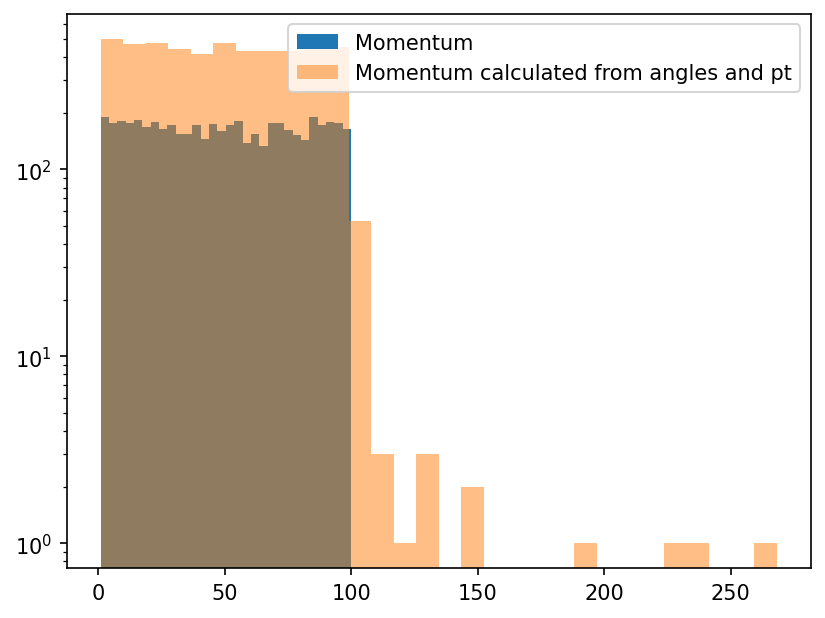

In [12]:
plt.hist(sig['p'],bins=30,label="Momentum")
plt.hist(sig['p_from_angles'],bins=30,label="Momentum calculated from angles and pt",alpha=0.5)
plt.yscale("log")
plt.legend()
plt.show()

Setting the histogram bins to be the collective range for the input arrs
p max is 99.9944 and min is 1.02321
p from cota and cotb max is 268.20094749673507 and min is 1.0223543825809853
So bins go from 1.0223543825809853 to 268.20094749673507, and there are 30 bins with linear spacing


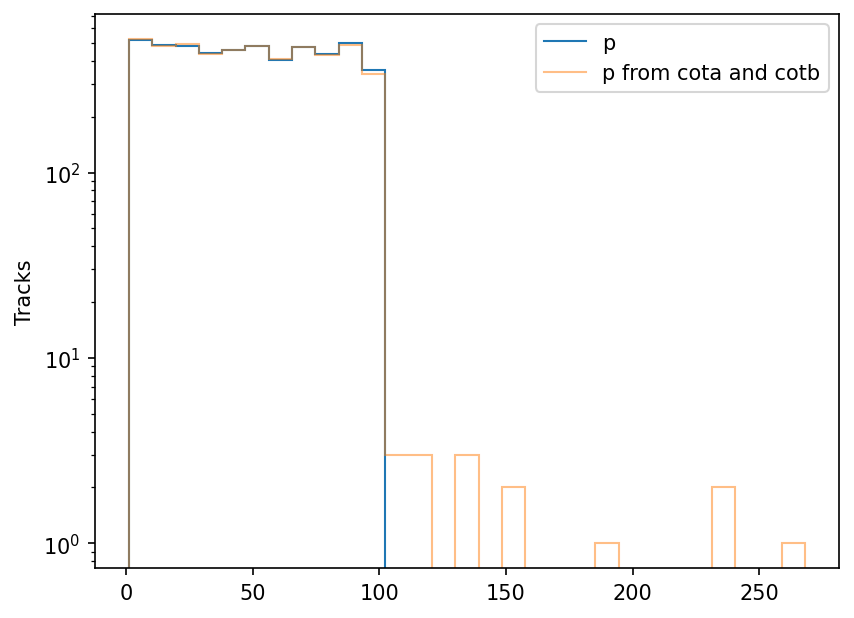

In [13]:
plotManyHisto([sig["p"],sig["p_from_angles"]],pltLabels=["p","p from cota and cotb"],pltStandalone=False,yscale="log",alphas=[1,0.5])


In [14]:
sig[abs(sig['p']-sig['p_from_angles'])>10]

,cota,cotb,p,flp,ylocal,zglobal,pt,t,hit_pdg,hit_x,...,prodz,gamma,phi,theta,moduleID,vec0,vec1,vec11,Q,p_from_angles
294,0.41041,-0.07988,33.33221,0,0.625,-39.975,20.41146,0.19820,-13,-27.62627,...,0.72099,2.74889,-0.31298,1.18246,8,"(0.9514202679462148, -0.30789523176098843)","(0.0796382315242257, -0.996823832018323)","(-0.07962636343537544, 0.9968247801123613)",1.0,22.053526
296,0.39799,-0.37343,33.33221,0,0.600,-38.525,20.41146,0.21413,-13,-27.64223,...,0.72099,2.74889,-0.03530,1.21392,8,"(0.9993770196948247, -0.03529266929391755)","(0.34984219949593026, -0.9368086439886482)","(-0.3498336448819236, 0.9368118385826623)",1.0,21.784020
532,-3.30090,-1.66431,79.97203,0,-7.975,18.900,66.65602,0.12510,-13,-18.90755,...,-1.86582,1.96350,2.99325,0.53171,6,"(-0.9890173905985964, 0.14779919178920878)","(-0.8571702576881082, 0.5150331536269313)","(-0.8571714699749087, 0.5150311360112652)",1.0,131.470029
534,3.62696,-2.49680,79.97203,0,3.425,22.450,66.65602,0.14405,-13,-18.88620,...,-1.86582,2.35619,0.40445,0.63808,7,"(0.9193189684588188, 0.39351319448248917)","(0.9283141944234765, -0.3717966600601622)","(-0.9283124950182081, 0.3718009031633323)",1.0,111.904145
535,0.12794,0.10921,79.97203,0,3.750,23.950,66.65602,0.15855,-13,-18.66141,...,-1.86582,2.35619,2.24741,1.69730,7,"(-0.6261563084712749, 0.7796975550568473)","(0.1085655930014784, 0.9940892877484584)","(0.10856450410218538, 0.9940894066677537)",1.0,67.192962
737,-0.03785,-0.14326,93.82390,0,0.425,45.750,53.24897,0.17737,-13,11.92777,...,2.00142,1.17810,1.32039,1.53334,4,"(0.24779763389916123, 0.9688118148711736)","(-0.14181034140478455, 0.9898938463646789)","(-0.14181215520504845, 0.989893586521349)",1.0,53.286333
738,-0.01969,0.06827,93.82390,0,-1.500,45.725,53.24897,0.18771,-13,10.15624,...,2.00142,1.17810,-2.03166,1.59044,4,"(-0.4447218378243789, -0.8956687372919224)","(-0.06811456548360709, -0.9976775059952887)","(0.06811145781881234, 0.9976777181604269)",1.0,53.259243
739,-0.22773,-0.59290,93.82390,0,0.300,45.825,53.24897,0.19973,-13,11.82899,...,2.00142,1.17810,1.71328,1.37736,4,"(-0.14200205465791949, 0.9898663629363962)","(-0.5099958795217042, 0.8601768439518024)","(-0.5099980779624856, 0.8601755405000601)",1.0,54.260988
740,0.50815,0.93455,93.82390,0,-1.050,46.300,53.24897,0.20594,-13,10.58401,...,2.00142,1.17810,-2.71507,1.21531,4,"(-0.9104098553685808, -0.41370749962716397)","(-0.6827920383896215, -0.7306127786397837)","(0.6827931774460466, 0.7306117141362651)",1.0,56.800311
741,-0.25300,0.63107,93.82390,0,-0.525,45.575,53.24897,0.21360,-13,11.06165,...,2.00142,1.17810,0.61514,1.36002,4,"(0.816692664703587, 0.5770728649133958)","(0.5336917423685215, 0.8456790905110826)","(0.5336852780723464, 0.8456831699690152)",1.0,54.454146


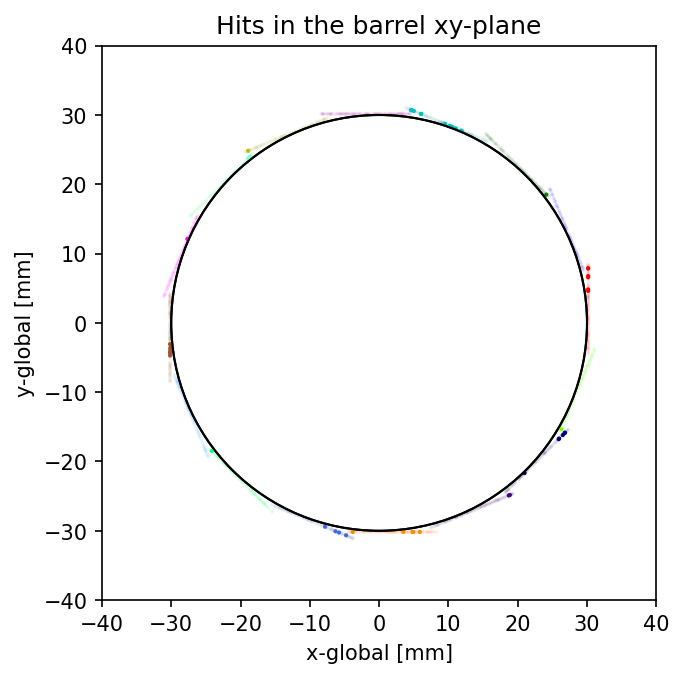

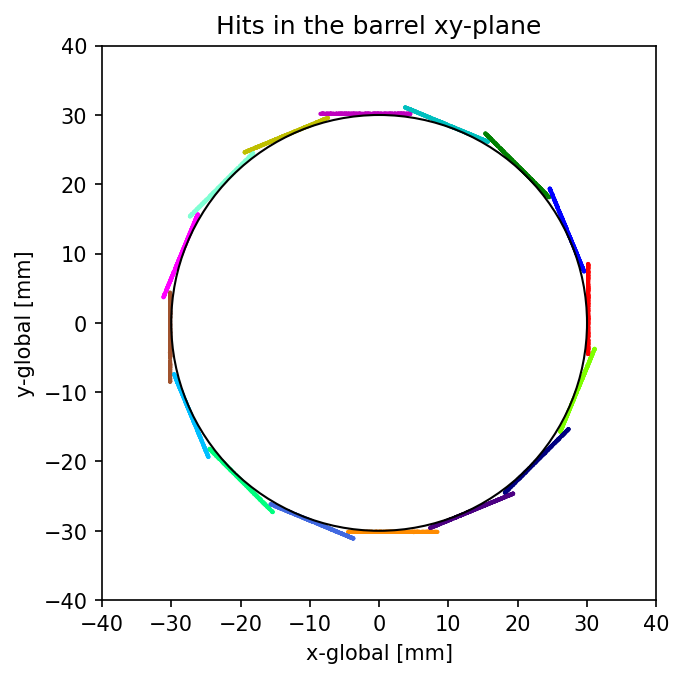

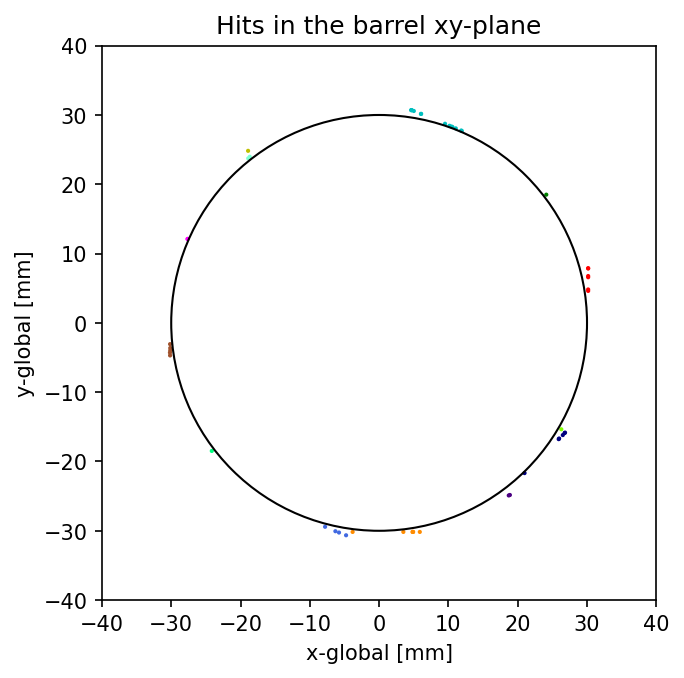

In [19]:
plotHits(sig,uniqueGammas,pltShow=False,alpha=0.01)
plotHits(sig[abs(sig['p']-sig['p_from_angles'])>10],uniqueGammas,pltStandalone=False)
plotHits(sig,uniqueGammas)
plotHits(sig[abs(sig['p']-sig['p_from_angles'])>10],uniqueGammas)

## New validation of better version of getYlocalAndGamma

[-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265  3.53429174]
50
      cota     cotb         p  flp  ylocal  zglobal        pt        t  \
0 -0.96579 -0.16332  79.90293    0  -4.925     29.3  57.83821  0.14096   

   hit_pdg   hit_x  ...    prodz   gamma      phi    theta  moduleID  \
0       13 -4.9192  ...  0.16922  1.5708  1.73269  0.80937         5   

                                        vec0  \
0  (-0.1611874056934765, 0.9869238168398848)   

                                        vec1  \
0  (-0.1611837805187884, 0.9869244089076281)   

                                       vec11    Q p_from_angles  
0  (-0.1611844759142578, 0.9869242953358917) -1.0      79.90296  

[1 rows x 24 columns]


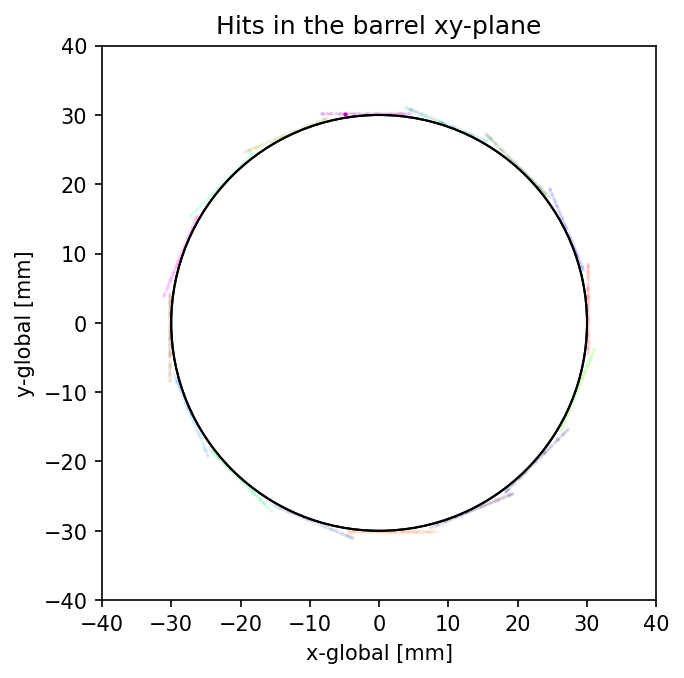

ylocal: 
      cota     cotb         p  flp  ylocal  zglobal        pt        t  \
1 -0.57681 -0.23414  33.05765    0   -7.05   17.325  28.82329  0.11861   

   hit_pdg    hit_x  ...    prodz    gamma     phi    theta  moduleID  \
1       13  7.04512  ... -0.07033  4.71239 -1.3408  1.05908        13   

                                        vec0  \
1  (0.2279739470572793, -0.9736672324070091)   

                                        vec1  \
1  (-0.2279729542911435, 0.9736674648522298)   

                                        vec11    Q p_from_angles  
1  (-0.22797441987519917, 0.9736671217015426) -1.0     33.057915  

[1 rows x 24 columns]


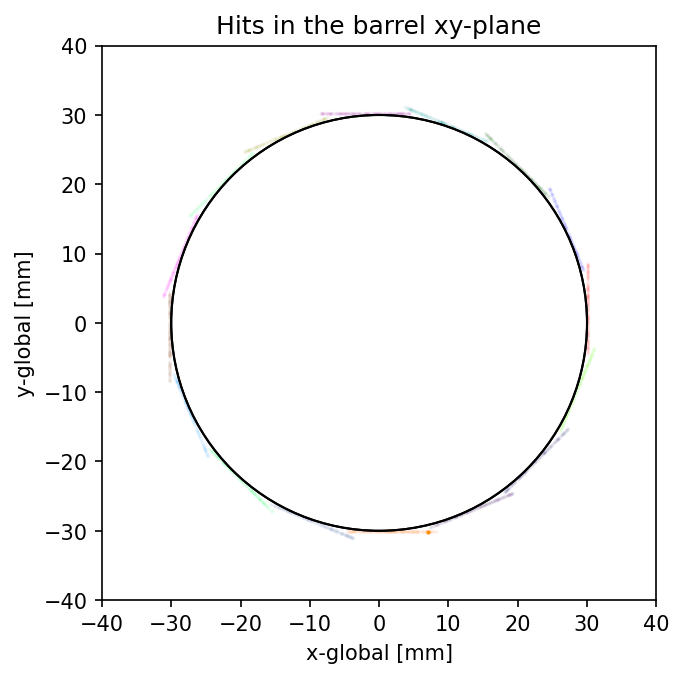

ylocal: 
      cota     cotb         p  flp  ylocal  zglobal        pt        t  \
2  1.10063 -0.10751  47.60314    0  -3.225  -30.825  32.11211  0.15013   

   hit_pdg    hit_x  ...    prodz    gamma     phi   theta  moduleID  \
2       13  3.22792  ...  2.37594  4.71239 -1.4637  2.4012        13   

                                         vec0  \
2  (0.10689171841656366, -0.9942706676423448)   

                                         vec1  \
2  (-0.10689070464291234, 0.9942707766302606)   

                                        vec11    Q p_from_angles  
2  (-0.10689401295729659, 0.9942704209589489) -1.0      47.60337  

[1 rows x 24 columns]


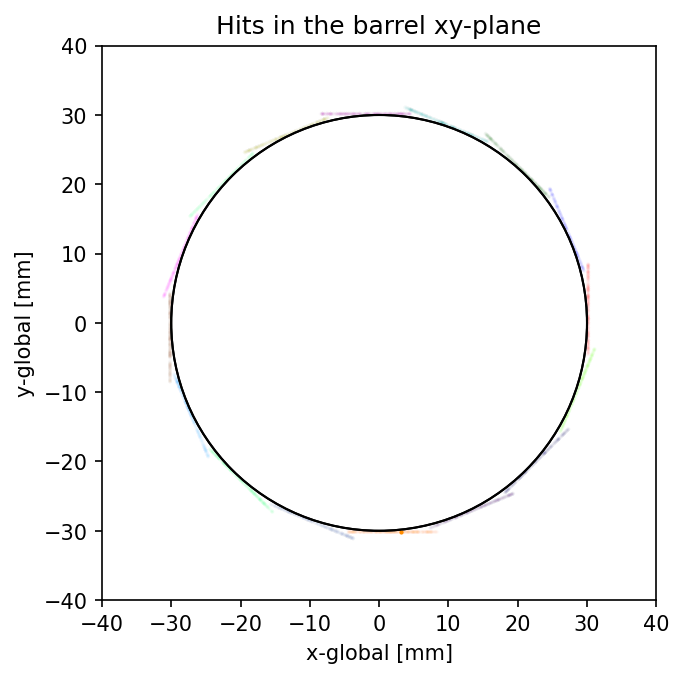

ylocal: 
      cota     cotb         p  flp  ylocal  zglobal       pt        t  \
3  0.54093 -0.13286  10.08954    0  -4.075    -18.7  8.89189  0.11531   

   hit_pdg     hit_x  ...    prodz    gamma     phi  theta  moduleID  \
3      -13 -18.45563  ... -2.37548  3.92699 -2.2241  2.063        11   

                                         vec0  \
3  (-0.6078130990893701, -0.7940801197457191)   

                                         vec1  \
3  (-0.13171148328728824, 0.9912880939314577)   

                                        vec11    Q p_from_angles  
3  (-0.13170269135819945, 0.9912892620668332)  1.0     10.089572  

[1 rows x 24 columns]


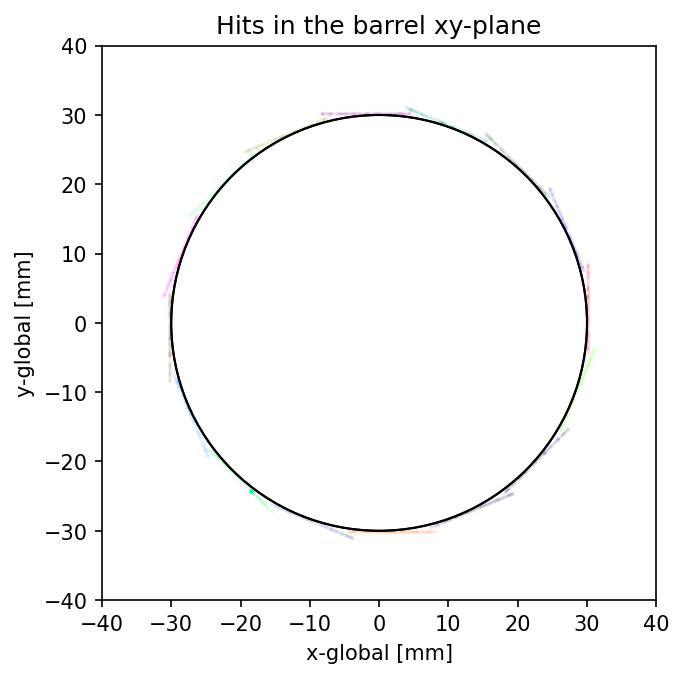

ylocal: 
      cota     cotb         p  flp  ylocal  zglobal        pt        t  \
4 -0.31497  0.08615  75.37355    0     2.6   11.125  71.91563  0.10594   

   hit_pdg     hit_x  ...   prodz    gamma      phi    theta  moduleID  \
4       13 -23.17143  ...  1.6246  3.92699 -2.44213  1.26672        11   

                                         vec0  \
4  (-0.7651882449087493, -0.6438066090476766)   

                                        vec1  \
4  (0.08582896385644458, 0.9963098860110388)   

                                       vec11    Q p_from_angles  
4  (0.08583207360030524, 0.9963096181114944) -1.0     75.373455  

[1 rows x 24 columns]


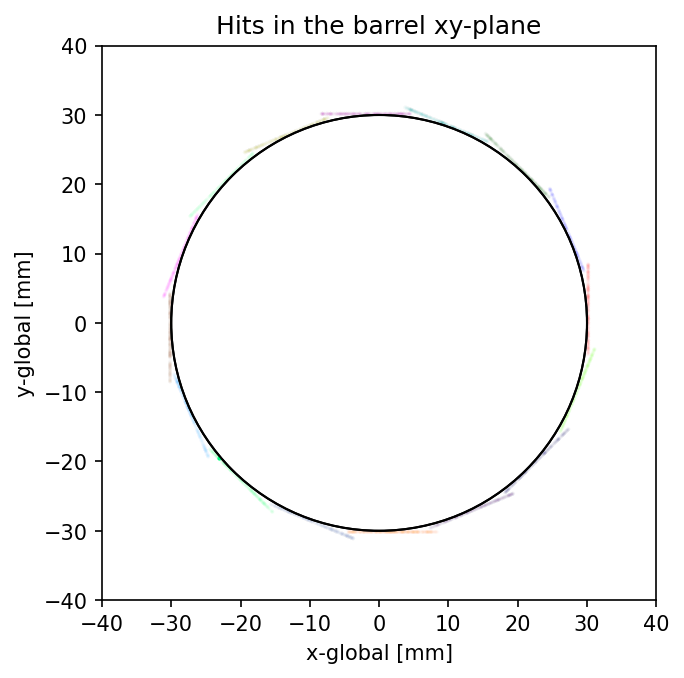

ylocal: 
      cota     cotb        p  flp  ylocal  zglobal        pt       t  hit_pdg  \
5 -0.50418 -0.02353  28.5728    0  -0.725     16.2  25.51496  0.1128      -13   

      hit_x  ...    prodz    gamma      phi    theta  moduleID  \
5 -21.84583  ...  0.98319  2.35619  2.37972  1.10393         7   

                                        vec0  \
5  (-0.7235446293391727, 0.6902776031093861)   

                                          vec1  \
5  (-0.023527828786610493, 0.9997231823222806)   

                                         vec11    Q p_from_angles  
5  (-0.023523488883099925, 0.9997232844496355)  1.0     28.572846  

[1 rows x 24 columns]


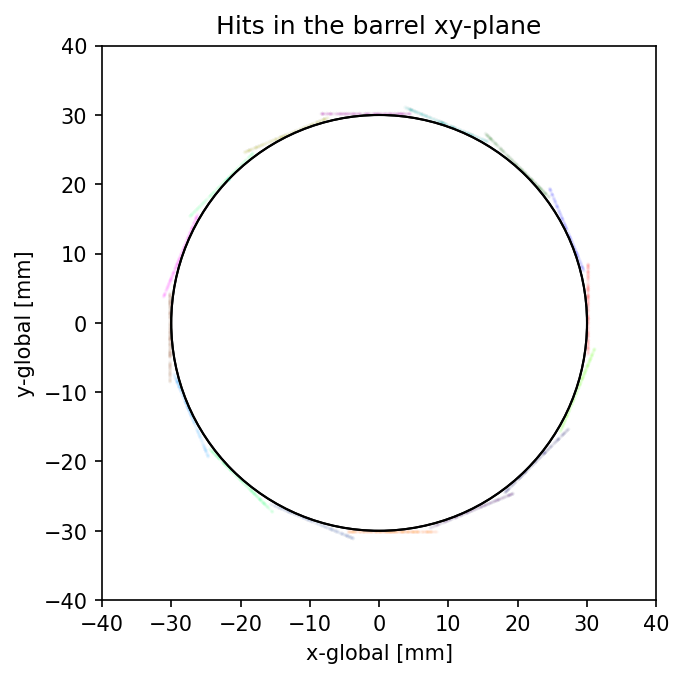

ylocal: 
      cota    cotb         p  flp  ylocal  zglobal        pt        t  \
6  0.28198 -0.0488  46.63809    0  -1.475   -11.15  44.89163  0.10475   

   hit_pdg     hit_x  ...    prodz    gamma      phi    theta  moduleID  \
6      -13 -10.17251  ... -2.64843  4.31969 -1.91474  1.84533        12   

                                         vec0  \
6  (-0.3372024055316988, -0.9414321737138771)   

                                         vec1  \
6  (-0.048735993597804755, 0.998811695430142)   

                                        vec11    Q p_from_angles  
6  (-0.04874199644245893, 0.9988114025094044)  1.0     46.638144  

[1 rows x 24 columns]


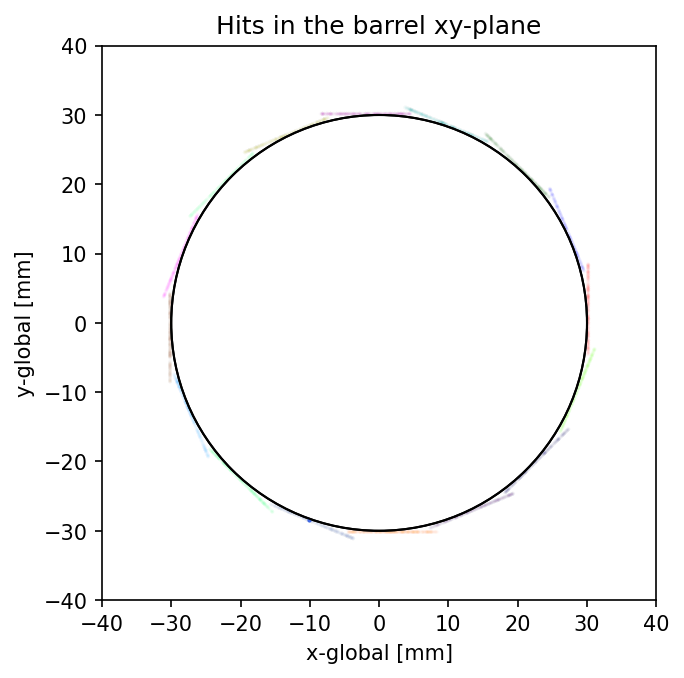

ylocal: 
     cota     cotb         p  flp  ylocal  zglobal        pt        t  \
7 -1.2078 -0.13524  93.62221    0  -4.075   38.125  60.02568  0.15849   

   hit_pdg    hit_x  ...    prodz   gamma      phi    theta  moduleID  \
7       13 -4.07071  ...  1.68853  1.5708  1.70522  0.69601         5   

                                         vec0  \
7  (-0.13401920569843226, 0.9909787346376113)   

                                         vec1  \
7  (-0.13401556562938272, 0.9909792269109563)   

                                        vec11    Q p_from_angles  
7  (-0.13401995045101048, 0.9909786339175576) -1.0     93.620419  

[1 rows x 24 columns]


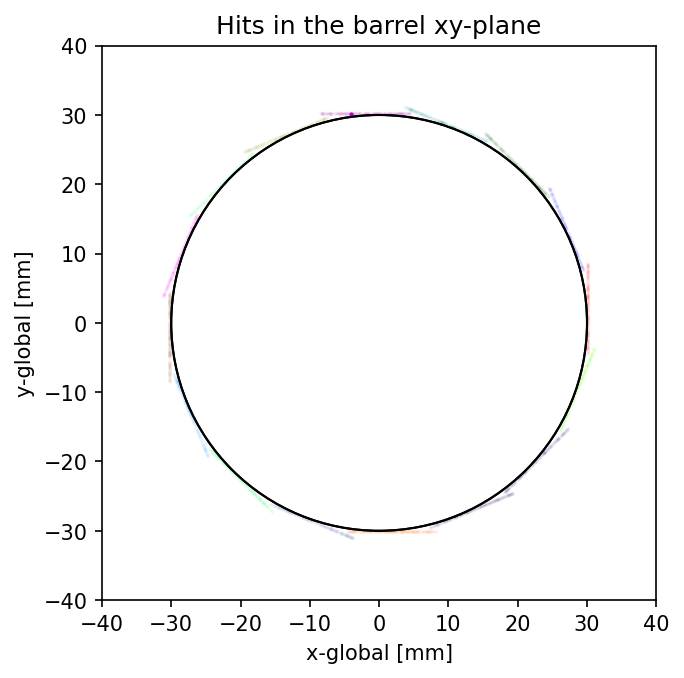

ylocal: 
      cota     cotb         p  flp  ylocal  zglobal       pt        t  \
8  0.52409  0.03873  15.14225    0   1.125    -14.4  13.4141  0.11376   

   hit_pdg     hit_x  ...    prodz    gamma      phi    theta  moduleID  \
8      -13 -12.58972  ...  1.41192  4.31969 -2.00221  2.05322        12   

                                         vec0  \
8  (-0.4181553659736538, -0.9083755225166735)   

                                         vec1  \
8  (0.038705022437830534, 0.9992506798787214)   

                                       vec11    Q p_from_angles  
8  (0.03870098488839552, 0.9992508362611804)  1.0     15.142249  

[1 rows x 24 columns]


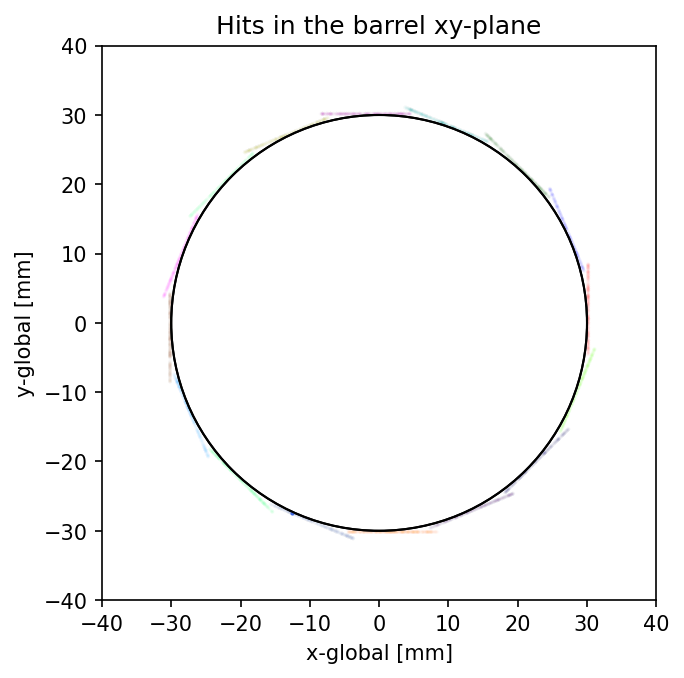

ylocal: 
      cota     cotb         p  flp  ylocal  zglobal       pt        t  \
9 -0.85423  0.12557  12.86626    0    3.75     26.8  9.81549  0.13302   

   hit_pdg     hit_x  ...    prodz    gamma      phi    theta  moduleID  \
9      -13 -14.99717  ...  1.04166  4.31969 -2.08842  0.86771        12   

                                         vec0  \
9  (-0.49481651489203454, -0.868997477896283)   

                                        vec1  \
9  (0.12460001342386116, 0.9922070533183956)   

                                       vec11    Q p_from_angles  
9  (0.12459157278035903, 0.9922081132464683)  1.0     12.866837  

[1 rows x 24 columns]


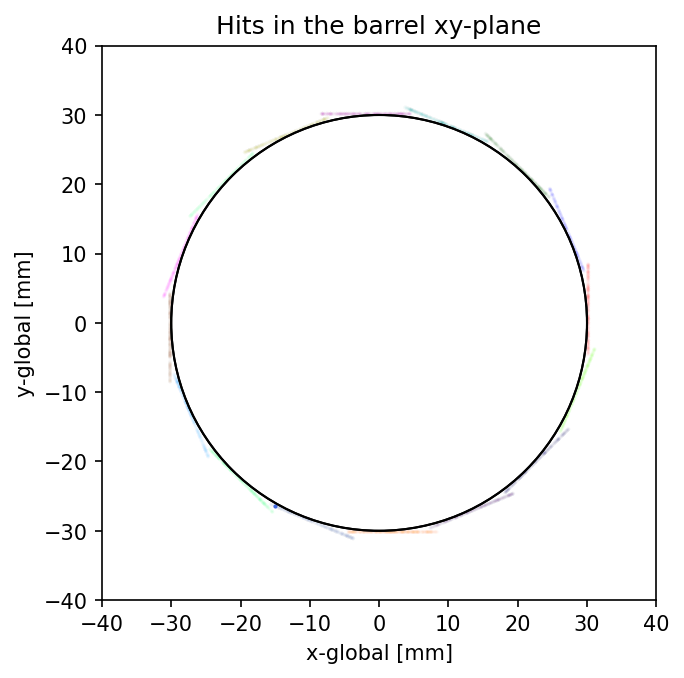

ylocal: 


In [16]:
sensorAngles2 = np.arange(-np.pi,np.pi+2*np.pi/8,np.pi/8)
print(sensorAngles2)


badSig = sig[abs(sig['p']-sig['p_from_angles'])>10]
print(len(badSig))
for i in range(10):
    ylocal, gamma, moduleID = getYlocalAndGamma(sig['hit_x'][i],sig['hit_y'][i])
    print(sig.loc[i:i])
    plotHits(sig,uniqueGammas,pltShow=False,alpha=0.01)
    plotHits(sig.loc[i:i],uniqueGammas,pltStandalone=False)
    print(f"ylocal: ")

In [17]:
x=np.sqrt(3)/2
y=1/2
np.arctan2(y,x)/np.pi

0.16666666666666669

In [18]:
1/6

0.16666666666666666